In [1]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from PIL import ImageOps
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
import imutils
import operator
from PIL import Image

Una vez tenemos todas la bibliotecas importadas, creamos la clase Red

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Capas que componen el cuerpo:
        self.body= nn.Sequential(
        #Primera capa convolucional:
        nn.Conv2d(in_channels= 1, out_channels= 32,kernel_size= 5),
        #Capa Maxpooling:
        nn.MaxPool2d(kernel_size= 2),
        #Capa función ReLU:
        nn.ReLU(inplace= True),
        #Segunda capa convolucional:
        nn.Conv2d(in_channels= 32, out_channels= 128, kernel_size= 5),
        #Capa función ReLU:
        nn.ReLU(inplace= True),
        #Capa MaxPolling:
        nn.MaxPool2d(kernel_size= 2),
        #Capa Dropout:
        nn.Dropout2d(),
        #Capa función ReLU:
        nn.ReLU(inplace= True)
        )
        
        #Capas que componen la cabeza:
        self.head= nn.Sequential(
        #Capa de entrada:
        nn.Linear(in_features= 3200, out_features= 2048),
        #Capa funcional ReLu:
        nn.ReLU(inplace= True),
        #Capa fully connected:
        nn.Linear(in_features= 2048, out_features= 512),
        #Capa funcional ReLU:
        nn.ReLU(inplace= True),
        #Capa de salida:
        nn.Linear(in_features= 512, out_features= 47))

    def forward(self, x):
        
        x= self.body(x)
        x= x.view(x.size()[0], -1)
        x= self.head(x)
        
        return x

Necesitamos un identificador de cada número y letra para el posterior entrenamiento

In [3]:
idt = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N',
       'O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [4]:
#La función PIL permite abrir una imagen y tratarla para convertirla
#a un estilo determinado.
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

A continuación se muestra la parte de entrenamiento

In [5]:
#A la función train se le pasa el número de épocas,
#el modelo de la red, el optimizador y el conjunto de datos:
def train(epoch, model, optimizer, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.cpu(), target.cpu() 
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()
        output = loss(output, target)
        output.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                 epoch, output.data.item()))

Se define una función de predicción de los caracteres

In [6]:
#Función para predecir el caracter alfanumérico:
def predecir_char(gray, model):
    w = gray.size[0] #Ancho
    h = gray.size[1] #Alto
    gray = gray.convert('L') #Pasar a gris
    gray = gray.point(lambda x: 0 if x<180 else 255, '1')
    x= int(16- (w/2)) #Esquina x de la caja
    y = int(16- (h/2))#Esquina y de la caja
    canvas = Image.new('L', (32, 32), (255)) #Transformar la imagen a una 32*32
    canvas.paste(gray, box=(x, y)) #Copiar la caja en la imagen
    canvas = np.array(canvas) #Pasar a array
    test_output = model(Variable(torch.FloatTensor(canvas).unsqueeze(0).unsqueeze(0).cpu())) #Pasar a tensor
    pred = test_output.data.max(1, keepdim=True)[1] 
    pred = np.array(pred).squeeze(0).squeeze(0)
    plt.imshow(canvas) #Mostrar resultado
    plt.show()
    return idt[pred]

Necesitamos definir una función de segmentación para separar los caracteres de
la matrícula y mirar si coincide con alguno de los caracteres almacenados

In [7]:
def digit_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Pasar a gris
    thresh = cv2.threshold(gray, 85, 240, cv2.THRESH_BINARY)[1] #Aplicar threshold binario
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0] #Sacar los contornos
    digits = {} #Crear un diccionario para los dígitos
    for c in cnts: #Recorrer todos los contornos de la imagen
        (x, y, w, h) = cv2.boundingRect(c)
        if (w > 90 and w < 300) and (h > 90 and h < 300): #Si se encuentra en estos umbrales, puede ser dígito
            cv2.rectangle(image, (x - 10, y - 10), (x + w + 10, y + h + 10), (255, 0, 0), 5) #Creamos un rectángulo
            roi = thresh[y : y + h, x : x + w]
            digits[x] = roi #Guardamos la región de interés en el diccionario

    return digits

def save_digits(images):
    for idx, image in enumerate(images): #Para cada ídice e imagen
        image = cv2.resize(image, (28, 32), interpolation = cv2.INTER_CUBIC) #Redimensionar
        image = roi_center(image) #Centrar el dígito de la imagen
        cv2.imwrite('./Test/test{}.jpg'.format(idx), image) #Guardar la imagen recortada con el caracter


def roi_center(roi):
    ALTURA_ROI = 28
    ANCHURA_ROI = 32
    ANCHO_BORDE = 4

    relacion_aspecto_roi = float(roi.shape[1]) / float(roi.shape[0]) #Ratio de la región de interés
    nueva_anchura = int((ALTURA_ROI * relacion_aspecto_roi) + 0.5)
    b_top = ANCHO_BORDE
    b_bottom = ANCHO_BORDE
    b_left = int((ANCHURA_ROI - nueva_anchura) / 2)
    b_right = int((ANCHURA_ROI- nueva_anchura) / 2)
    #Añadir unas dimensiones corregidas al borde de la región de interés 
    roi_borde = cv2.copyMakeBorder(roi,b_top,b_bottom,b_left,b_right,cv2.BORDER_CONSTANT,value=[255,255,255])
    roi_trans = cv2.resize(roi_borde,(32,32)) #Redimensionar esa región
    return roi_trans


image_src = cv2.imread("./matriculas/matricula8.jpg") #Leemos la imagen
image_src = imutils.resize(image_src, height=800) #Redimensionamos
result = digit_segmentation(image_src)
result_sort = sorted(result.items(), key=operator.itemgetter(0)) #Almacenar el diccionario de dígitos
final_result = []

for r in result_sort:
    #print r[0]
    final_result.append(r[1])

save_digits(final_result)

Entrenamos el modelo

In [ ]:
if __name__ == "__main__":
    
    trans = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
    mydata = dset.ImageFolder('./caracteres',transform=trans, loader=pil_loader)
    loader = torch.utils.data.DataLoader(mydata, batch_size=128, shuffle=True, num_workers=2)

    model = Net()
    model.cpu()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-4)
    for epoch in range(10):
        train(epoch, model, optimizer, loader)
    torch.save(model.state_dict(), 'char_recognizer.pt')

Hacemos la prueba con los pesos de la red y las imágenes de test

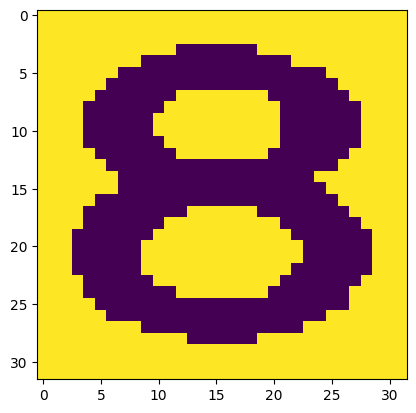

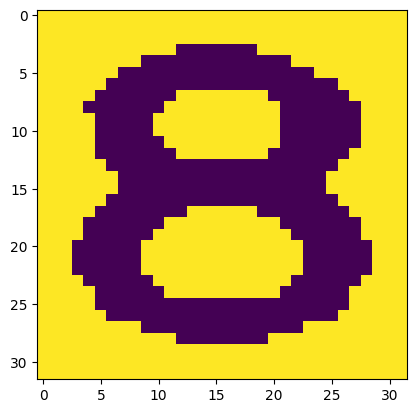

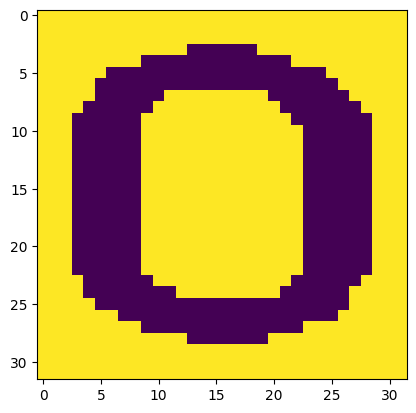

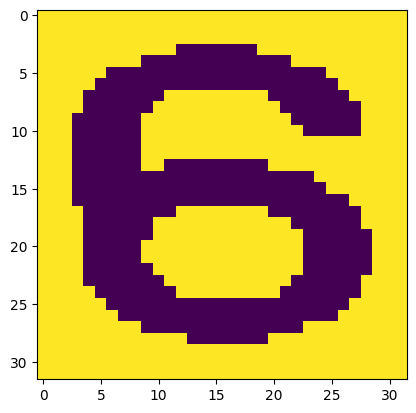

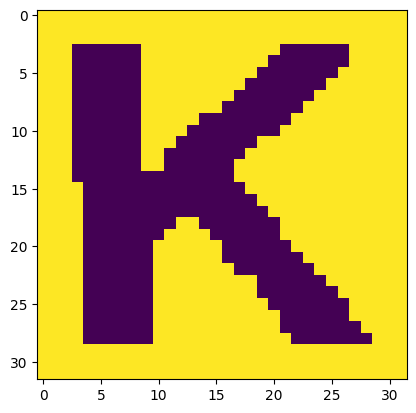

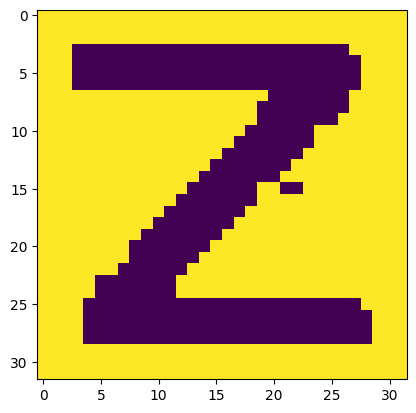

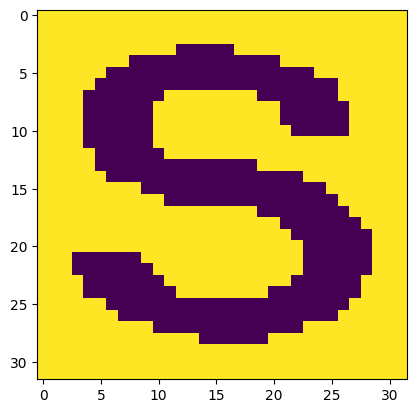


La matricula es:   88OBKZS


In [9]:
#Devolvemos el resultado:
model.load_state_dict(torch.load("char_recognizer.pt"))
model.cpu()

res = ""
for i in range(7):
    pil_im = Image.open("./Test/test{}.jpg".format(i))
    res += predecir_char(pil_im, model)
print ('\nLa matricula es:  ', res)